In [16]:
from pathlib import Path
import os
import json
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [17]:
def plot_episode_len(params: np.array, data: np.array, row=None, col=None, plot=None, xlabel='', ylabel='', rowdict={}, coldict={}):
    """
    General-use function for plotting a episode length

    args: 
        params : np.array shape (num_runs, num_params) with parameters for each run
        data : np.array shape (num_runs, num_timesteps) with data
        row : index of parameters, this function will generate a subplot for each unique setting
        col : index of parameters, this function Will generate a subplot for each unique setting
        plot : index of parameters, for which a new line will be added to a subplot for each unique value
        
    """

    nrows = np.unique(params[:, row]).shape[0]
    ncols = np.unique(params[:, col]).shape[0]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, squeeze=False, figsize=(10,10))

    row_idx = 0
    for row_param in np.unique(params[:, row]):
        col_idx = 0
        for col_param in np.unique(params[:, col]):
            for plot_param in np.unique(params[:, plot]):
                inds = np.where(
                    (params[:, row]==row_param) & 
                    (params[:, col]==col_param) & 
                    (params[:, plot]==plot_param))
                
                ax = axs[row_idx, col_idx]
                for run_data in data[inds]:
                    if len(run_data) > 1:
                        ax.plot(np.arange(len(run_data)),  run_data)
                    else:
                        ax.scatter([0], run_data)
                   

                ax.set_title('%s, %s' % (rowdict.get(row_param, row_param), coldict.get(col_param, col_param)))
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_yscale('log')
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                
            col_idx += 1
        row_idx += 1

    fig.tight_layout()


In [18]:
root = Path('results_batch_size')
filters = None
params, episode_len = extract_epsisode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'batch_size'], filters)


#plot_rewards(params, times, plot=[0,5], plot_fmt='%s, %s', xlabel="Step", ylabel="Average Reward", title='', window=1)

In [19]:
params

array([['RNN', 'CartPole-v1', '8479', ..., '100', '1', '4'],
       ['RNN', 'CartPole-v1', '8479', ..., '100', '1', '16'],
       ['RNN', 'CartPole-v1', '8479', ..., '100', '4', '32'],
       ...,
       ['RNN', 'CartPole-v1', '438', ..., '100', '1', '16'],
       ['RNN', 'CartPole-v1', '438', ..., '100', '1', '32'],
       ['RNN', 'CartPole-v1', '438', ..., '100', '1', '64']], dtype='<U11')

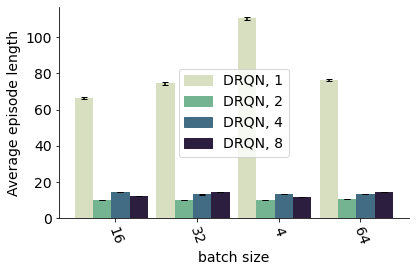

In [21]:

plot_avg_episode_length(params, episode_len, categories=[6], shapes=[0, 5], tick_fmt='%s', shape_fmt = '%s, %s', xlabel='batch size', ylabel='Average episode length', title='')
plt.savefig("batch_size.pdf")